# PyTorch model
In this final notebook, we will be building our own custom PyTorch model to train and run predictions on.

In [1]:
# Import libraries

import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data

import matplotlib.pyplot as plt

In [2]:
data_dir = 'data'

## Building

Here, we will define the model. Our model will consist of two fully-connected hidden layers with ReLu activations. There will also be a dropout layer in between the second hidden layer and output layer. Since we want a continuous numerical value as output, our final layer will also be a fully-connected layer with one neuron.

In [3]:
import torch.nn.functional as F
import torch.nn as nn


class LinearRegressor(nn.Module):

    def __init__(self, input_dim):
        super(LinearRegressor, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        
        return x

## Training
We will use the _train_ function below to train the model. It supports early stopping in case our validation loss does not improve after a certain number of epochs and we want to stop training early.

In [43]:
def train(model, train_loader, validation_loader, epochs, criterion, optimizer, device, early_stop_patience = 10):
    min_validation_loss = float("inf")
    patience = early_stop_patience
    
    for epoch in range(1, epochs + 1):
        model.train() # Make sure that the model is in training mode.

        train_loss = 0

        for batch in train_loader:
            # get data
            batch_x, batch_y = batch

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            # get predictions from model
            y_pred = model(batch_x)
            
            # perform backprop
            loss = criterion(y_pred, batch_y)            
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
        else:    
            model.eval()

            validation_loss = 0

            with torch.no_grad():
                for batch in validation_loader:
                    batch_x, batch_y = batch

                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)

                    # get predictions from model
                    y_pred = model(batch_x)

                    loss = criterion(y_pred, batch_y)

                    validation_loss += loss.item()
                    
            validation_loss /= len(validation_loader)
            
            if validation_loss < min_validation_loss:
                patience = early_stop_patience
                
                print('New validation loss minimum reached. Saving checkpoint')
                
                min_validation_loss = validation_loss
                
                torch.save(model.state_dict(), 'checkpoint.pth')
            else:
                patience -= 1
                
                if patience == 0:
                    print('Early stopping condition reached. Stopping training')
                    
                    break

        print("Epoch: {}, Train loss: {}, Validation loss: {}".format(epoch, train_loss / len(train_loader), validation_loss))

We load in the training and validation dataset. 

Since we are using a custom model, we will have to implement normalization ourselves. We will use scikit-learn's MinMaxScaler for normalization. What it does is it scales the values in each column from 0-1 based on the value's ratio to the minimum and maximum value of the column it is in. More on MinMaxScaler here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html. To remain consistent with the behaviors of the LinearLearner and XGBoost model, we will will not normalize the price label.

In [4]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None)
validation_data = pd.read_csv(os.path.join(data_dir, 'validation.csv'), header=None)

In [5]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

train_data_np = train_data.values
train_data_np_y = train_data_np[:, 0]
train_data_np = min_max_scaler.fit_transform(train_data_np)
train_data_np[:, 0] = train_data_np_y

validation_data_np = validation_data.values
validation_data_np_y = validation_data_np[:, 0]
validation_data_np = min_max_scaler.transform(validation_data_np)
validation_data_np[:, 0] = validation_data_np_y

After normalization, we can now format the train and validation dataset to be put into a DataLoader which we will use for training the model.

In [6]:
train_y = torch.from_numpy(train_data_np[:,[0]]).float()
train_x = torch.from_numpy(train_data_np[:,1:]).float()

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)

validation_y = torch.from_numpy(validation_data_np[:,[0]]).float()
validation_x = torch.from_numpy(validation_data_np[:,1:]).float()

validation_dataset = torch.utils.data.TensorDataset(validation_x, validation_y)

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Here, we will instantiate the model by supplying it with the input dimensions of our dataset.

We will use a learning rate of 0.001. As for the optimizer and loss function, I have decided to use Adam and Mean Squared Error(MSE).

In [9]:
model = LinearRegressor(train_x.shape[1])
model.to(device)

lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

We start training for maximum of 300 epochs.

In [58]:
epochs = 300

train(model, train_dataloader, validation_dataloader, epochs, criterion, optimizer, device)

New validation loss minimum reached. Saving checkpoint
Epoch: 1, Train loss: 843259303.4766355, Validation loss: 556914428.3076923
New validation loss minimum reached. Saving checkpoint
Epoch: 2, Train loss: 536134031.7009346, Validation loss: 148743276.30769232
New validation loss minimum reached. Saving checkpoint
Epoch: 3, Train loss: 202468473.79439253, Validation loss: 112412676.61538461
New validation loss minimum reached. Saving checkpoint
Epoch: 4, Train loss: 152573312.0, Validation loss: 99485026.15384616
New validation loss minimum reached. Saving checkpoint
Epoch: 5, Train loss: 132132815.51401868, Validation loss: 85917260.92307693
New validation loss minimum reached. Saving checkpoint
Epoch: 6, Train loss: 114693307.88785046, Validation loss: 75321177.84615384
New validation loss minimum reached. Saving checkpoint
Epoch: 7, Train loss: 99769578.80373831, Validation loss: 65968213.23076923
New validation loss minimum reached. Saving checkpoint
Epoch: 8, Train loss: 8695441

We can observe a similar scale for the validation loss compared to the models we have worked on prior. Again, the very high loss is due to the unnormalized price labels. Going through the logs, we can see that the validation loss decreased from 556914428.31 to 26712609.23 before early stopping kicked in.

## Evaluation

Now we can run predictions on the trained model. After we load in the test data, we still have some processing to do. Since we trained the model with normalized features, we will have to normalize the test dataset features before inference too in order to get predictions in similar scale. It is important that we transform/normalize the test data with the same scaler we used to normalize the training dataset to ensure that both datasets are scaled equally.

In [16]:
model.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [17]:
X_test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None)
y_test_df = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None)

X_test = X_test_df.values
y_test = y_test_df.values

In [18]:
test_data_np = np.concatenate([y_test, X_test], axis=1)
test_data_np_y = test_data_np[:, 0]
test_data_np = min_max_scaler.transform(test_data_np)
test_data_np[:, 0] = test_data_np_y

In [19]:
test_input = torch.from_numpy(test_data_np[:,1:]).float()

model.eval()

with torch.no_grad():
    predictions = model(test_input.to(device))
    
predictions = predictions.cpu().detach().numpy()
labels = y_test

In [20]:
fig_dir = 'fig'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

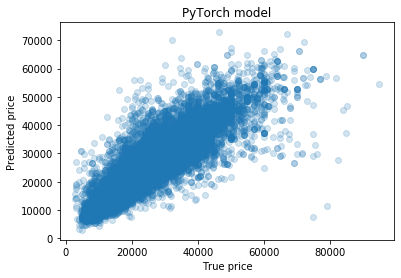

In [21]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("PyTorch model")
plt.savefig(os.path.join(fig_dir, 'pytorch_pred.jpg'))

We can observe from the plot that our PyTorch model performed similarly to the XGBoost model - a mostly straight plot but with some outliers.

### R-squared score

To measure accuracy, we will again use R-squared score.

In [22]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.7699063746869551


The PyTorch model's accuracy is a little below the XGBoost model at 0.77. Along with this, other metrics below are also very close to that of the XGBoost model.

In [23]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.056640625
Max distance: 67580.33642578125
Mean distance: 3468.076180230625


## Conclusion

The models we have built and trained seem to be generally performing well except for the alarmingly high value of max distance for each of them. This high value is also most likely what is causing our accuracy score to not be in the .80-.90 range. Let's take a look at what this max distance actually is.

In [24]:
encoded_df = pd.read_csv(os.path.join(data_dir, 'vehicles_encoded.csv'))

columns = encoded_df.columns

X_test_df.columns = columns[2:]

max_distance_row_idx = np.unravel_index(np.argmax(distances), distances.shape)[0]

max_row_df = X_test_df.iloc[[max_distance_row_idx]]

print('Max distance car true price: {}'.format(labels[max_row_df.index[0]][0]))

Max distance car true price: 75000.0


If take a look at the actual car price of the car that has the max distance from the predicted price, it is 75000. In order to put this price in perspective, we need to find the car's model.

In [25]:
model_columns = [c for c in X_test_df.columns if c.startswith('model_')]

max_row_df_models = max_row_df[model_columns]

model_idx = np.where(max_row_df_models.values.squeeze() == 1)[0][0]

model = model_columns[model_idx]

print('Max distance car model: {}'.format(model))

Max distance car model: model_hyundai-elantra


After finding out that the car is a Hyundai Elantra, a quick search on how much it is on the US used cars market yields that its price ranges from 5000-11000 USD, way beyond its label price in our dataset.

In [26]:
test_data = pd.concat([pd.DataFrame(data={'price':y_test.squeeze()}), X_test_df], axis=1)

test_df_model_idx = list(test_data.columns).index(model)

model_test_df = test_data[test_data.iloc[:, test_df_model_idx] == 1]

print('Max distance car model mean price: {}'.format(model_test_df.iloc[:, 0].mean()))

Max distance car model mean price: 12317.555970149253


We can also put the high price in context in terms of our dataset by getting the mean price of all Hyundai Elantra cars we have in our test dataset. We get a mean of 12000 USD. This, again, is way below the label. So we can conclude that this is an outlier in the dataset.

This actually proves that our model works. The objective of this project is to build a model that can estimate a market-average price for used cars in order to help buyers and sellers avoid inflated car prices on the consumer-to-consumer market.

So when John Doe heads to Craigslist looking to buy a used Hyundai Elantra priced at 75000 USD, running its specs on our model will make him realize that this particular Hyundai Elantra's price is well above market and he should look somewhere else.

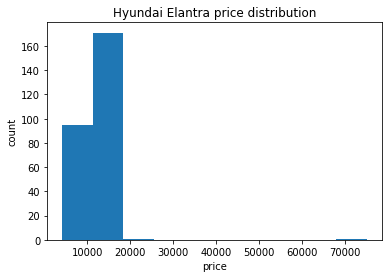

In [31]:
plt.hist(model_test_df.iloc[:, 0])
plt.xlabel('price')
plt.ylabel('count')
plt.title('Hyundai Elantra price distribution')
plt.savefig(os.path.join(fig_dir, 'elantra_price_distribution'))